Synthesize Criteo data using sequential CART models. (Note that this file uses the updated synthesis and optimization functions from the `helper_functions.py` file.).

In [1]:
import matplotlib.pyplot as plt
import sys

# Add the parent directory to path
sys.path.append('..')

# Then import
from helper_functions import *

rng = np.random.RandomState(42)

Import Criteo data (small version for testing)

In [2]:
# train_data = pd.read_csv("../../Data/Criteo/cleaned_criteo_small.gz",
#                          compression='gzip', 
#                          sep='\,',
#                          header=0,
#                          engine='python')
# data_set = "small"

train_data = pd.read_csv("../../Data/Criteo/cleaned_criteo.gz",
                         compression='gzip', 
                         sep='\,',
                         header=0,
                         engine='python')
data_set = "full"

View confidential data to synthesize.

In [3]:
train_data

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,treatment,conversion,visit,exposure
0,2.534995,2.308533,2.194602,107.757316,2.330251,61.279994,1.342378e+00,1.575636,52.216366,2.579463,1.667778,0.84478,1,0,0,0
1,2.534995,2.308533,2.197523,107.757316,2.330251,61.279994,1.342378e+00,1.575636,52.216366,2.579463,1.667778,0.84478,1,0,0,0
2,2.534995,2.308533,2.193303,107.757316,2.330251,61.279994,1.342378e+00,1.575636,52.216366,2.579463,1.667778,0.84478,1,0,0,0
3,2.534995,2.308533,2.197536,107.757316,2.330251,61.279994,1.342378e+00,1.575636,52.216366,2.579463,1.667778,0.84478,1,0,0,0
4,2.534995,2.308533,2.201438,107.757316,2.330251,61.279994,1.342378e+00,1.575636,52.216366,2.579463,1.667778,0.84478,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13979587,3.269484,2.308533,2.197919,107.757316,2.330251,61.279994,3.754896e-02,1.575636,46.505852,2.579463,1.667778,0.84478,1,0,0,0
13979588,2.537041,2.368327,2.105887,0.182664,2.330251,20.349663,8.696717e-07,1.835621,53.083067,2.579463,1.667778,0.84478,1,0,0,1
13979589,2.563144,2.308533,2.126071,2.322030,2.400581,61.279994,2.530380e-04,1.575636,43.781534,3.159982,1.819567,0.84478,1,0,1,0
13979590,3.211048,2.308533,2.105887,107.757316,2.330251,61.279994,2.757648e-01,1.575636,53.083067,2.579463,1.667778,0.84478,1,0,0,0


Determine the synthesis order.

In [4]:
# compute correlation matrix
correlation_matrix = train_data.corr()

In [5]:
tree_synthesis_order = list(np.abs(correlation_matrix).sum()[:12].sort_values(ascending=False).index)

In [6]:
tree_synthesis_order

['f8', 'f9', 'f4', 'f5', 'f0', 'f3', 'f11', 'f10', 'f6', 'f7', 'f1', 'f2']

Define order of synthesis. We first synthesize the joint distribution of the numeric features `f0`-`f11` using a Gaussian mixture model, followed by `treatment`, `exposure`, `visit` and `conversion` synthesized by sequential multinomial logit models.

In [7]:
# synthesis steps
# written as a list of tuples (features, model)

# synthesis steps
# written as a list of tuples (features, model)
synthesis_steps = [
    (['treatment', 'exposure', 'visit', 'conversion'], 'joint_categorical'),
    (tree_synthesis_order, 'tree'),
]

Fit unconstrained synthesis trees to find lower bound for synthesis bounds.

In [8]:
# define a list to contain all column names in order of synthesis
all_cols = synthesis_steps[0][0]

In [9]:
# add the remaining column names (the 'f' variables)
[all_cols.append(synthesis_steps[1][0][i]) for i in range(len(synthesis_steps[1][0]))]

[None, None, None, None, None, None, None, None, None, None, None, None]

In [10]:
all_cols

['treatment',
 'exposure',
 'visit',
 'conversion',
 'f8',
 'f9',
 'f4',
 'f5',
 'f0',
 'f3',
 'f11',
 'f10',
 'f6',
 'f7',
 'f1',
 'f2']

Estimate cart models for each f variable, conditional on the categorical variables, and previously modeled 'f' variables

In [11]:
all_leaf_sizes = []
transformed_targets = []

# loop over column indices from f0 to f11, with the categorical variables placed as the first four variables
for id in range(4, len(all_cols)):
    
    # define X variables
    covariates = train_data.loc[:, all_cols[:id]]

    # define Y variable
    target = train_data.loc[:, all_cols[id]]

    # transform target with Yeo-johnson
    pt = PowerTransformer(method='yeo-johnson', standardize=True)
    target = pt.fit_transform(target.to_numpy().reshape(-1, 1)).ravel()

    transformed_targets.append(target)

    # define and fit CART model
    # use min_samples_leaf = 1 for a tree unconstrained on leaf size
    tree = DecisionTreeRegressor(min_samples_leaf=1)
    tree.fit(covariates, target)

    # compute leaf assignments
    # obtain leaf assignments for training data
    train_leaves = tree.apply(covariates)
    # count the number of samples in each leaf
    all_leaf_sizes.append(np.unique(train_leaves, return_counts=True)[1])

C:\Users\cdbale\AppData\Roaming\Python\Python311\site-packages\numpy\core\_methods.py:239: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
C:\Users\cdbale\AppData\Roaming\Python\Python311\site-packages\numpy\core\_methods.py:250: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)


In [12]:
pd.Series([np.min(x) for x in all_leaf_sizes], index=all_cols[4:])

f8         4063
f9     13979592
f4     13979592
f5            1
f0            1
f3            1
f11           1
f10    13979592
f6            1
f7     13979592
f1     13979592
f2     13979592
dtype: int64

Set up dictionary of parameter bounds for the Bayesian optimization process. The current state of the code requires a set of bounds for each parameter being optimized.

In [13]:
param_bounds = {
    'tree': {
        'f0': {  # Applies to all tree-synthesized variables
            'min_samples_leaf': [10, 1000]  # [min, max] bounds
        },
        'f1': {  # Applies to all tree-synthesized variables
            'min_samples_leaf': [1, 1]  # [min, max] bounds
        },
        'f2': {  # Applies to all tree-synthesized variables
            'min_samples_leaf': [1, 1]  # [min, max] bounds
        },
        'f3': {  # Applies to all tree-synthesized variables
            'min_samples_leaf': [10, 1000]  # [min, max] bounds
        },
        'f4': {  # Applies to all tree-synthesized variables
            'min_samples_leaf': [1, 1]  # [min, max] bounds
        },
        'f5': {  # Applies to all tree-synthesized variables
            'min_samples_leaf': [10, 1000]  # [min, max] bounds
        },
        'f6': {  # Applies to all tree-synthesized variables
            'min_samples_leaf': [10, 1000]  # [min, max] bounds
        },
        'f7': {  # Applies to all tree-synthesized variables
            'min_samples_leaf': [1, 1]  # [min, max] bounds
        },
        'f8': {  # Applies to all tree-synthesized variables
            'min_samples_leaf': [4063, 10000]  # [min, max] bounds
        },
        'f9': {  # Applies to all tree-synthesized variables
            'min_samples_leaf': [1, 1]  # [min, max] bounds
        },
        'f10': {  # Applies to all tree-synthesized variables
            'min_samples_leaf': [1, 1]  # [min, max] bounds
        },
        'f11': {  # Applies to all tree-synthesized variables
            'min_samples_leaf': [10, 1000]  # [min, max] bounds
        }
    }
}

Define additional parameters of the optimization process:

- num_synthetic_datasets: Number of synthetic datasets to generate on each iteration of the optimizer (usually use 10 to reduce compute time)
- num_iter_optimization: Number of iterations to run the optimizer (default is 25, can run longer to try to find a better solution)
- num_init_optimization: Number of initializations to perform prior to optimized iterations (usually 3-5, this just starts the optimizer)
- random_states: run the optimizer all the way through for each random seed in this list

In [14]:
number_synthetic_datasets = 10
num_iter_optimization = 25
num_init_optimization = 5
random_states = [1006, 428]

Compute target parameters.

In [15]:
# reorder the columns in the training data to match the synthesis order
train_data = train_data[all_cols]

In [16]:
train_data

,treatment,exposure,visit,conversion,f8,f9,f4,f5,f0,f3,f11,f10,f6,f7,f1,f2
0,1,0,0,0,52.216366,2.579463,2.330251,61.279994,2.534995,107.757316,0.84478,1.667778,1.342378e+00,1.575636,2.308533,2.194602
1,1,0,0,0,52.216366,2.579463,2.330251,61.279994,2.534995,107.757316,0.84478,1.667778,1.342378e+00,1.575636,2.308533,2.197523
2,1,0,0,0,52.216366,2.579463,2.330251,61.279994,2.534995,107.757316,0.84478,1.667778,1.342378e+00,1.575636,2.308533,2.193303
3,1,0,0,0,52.216366,2.579463,2.330251,61.279994,2.534995,107.757316,0.84478,1.667778,1.342378e+00,1.575636,2.308533,2.197536
4,1,0,0,0,52.216366,2.579463,2.330251,61.279994,2.534995,107.757316,0.84478,1.667778,1.342378e+00,1.575636,2.308533,2.201438
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13979587,1,0,0,0,46.505852,2.579463,2.330251,61.279994,3.269484,107.757316,0.84478,1.667778,3.754896e-02,1.575636,2.308533,2.197919
13979588,1,1,0,0,53.083067,2.579463,2.330251,20.349663,2.537041,0.182664,0.84478,1.667778,8.696717e-07,1.835621,2.368327,2.105887
13979589,1,0,1,0,43.781534,3.159982,2.400581,61.279994,2.563144,2.322030,0.84478,1.819567,2.530380e-04,1.575636,2.308533,2.126071
13979590,1,0,0,0,53.083067,2.579463,2.330251,61.279994,3.211048,107.757316,0.84478,1.667778,2.757648e-01,1.575636,2.308533,2.105887


In [17]:
target_variable = 'conversion'
exog_variables = list(train_data.drop(target_variable, axis=1).columns)

In [18]:
target_params = logit_params(X = train_data[exog_variables], y = train_data[target_variable])

Use the `optimization_models` function to perform the optimized synthesis process. The function returns the objective value associated with each iteration, the best set of parameters for each random seed, and the final optimization object from the Bayesian optimization function.

In [ ]:
import warnings
warnings.filterwarnings('ignore')

# we are silencing harmless overflow warnings from numpy related to the Yeo-johnson transformation
# these warnings are not related to the optimization process and can be safely ignored

optimization_results = [optimize_models_with_param_target(train_data=train_data,
                                                          number_synthetic_datasets=number_synthetic_datasets,
                                                          synthesis_steps=synthesis_steps,
                                                          param_bounds=param_bounds,
                                                          random_state=r,
                                                          target_params=target_params,
                                                          target_variable=target_variable,
                                                          exog_variables=exog_variables,
                                                          n_iter=num_iter_optimization,
                                                          n_init=num_init_optimization) for r in random_states]

Optimizing 12 parameters: ['x0', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10', 'x11']
|   iter    |  target   |    x0     |    x1     |    x2     |    x3     |    x4     |    x5     |    x6     |    x7     |    x8     |    x9     |    x10    |    x11    |
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------
| 2         | -0.079309 | 745.69608 | 1.0       | 1.0       | 883.53190 | 1.0       | 724.05091 | 302.39436 | 1.0       | 5094.6399 | 1.0       | 1.0       | 263.95493 |
| 3         | -0.079309 | 244.86210 | 1.0       | 1.0       | 209.99043 | 1.0       | 980.92127 | 737.45582 | 1.0       | 7736.8821 | 1.0       | 1.0       | 609.36680 |
| 4         | -0.079309 | 455.98215 | 1.0       | 1.0       | 296.13639 | 1.0       | 818.60998 | 272.37946 | 1.0       | 8038.9238 | 1.0       | 1.0       | 837.81185 |


In [ ]:
run_targets = [np.minimum.accumulate(-i['optimizer'].space.target) for i in optimization_results]

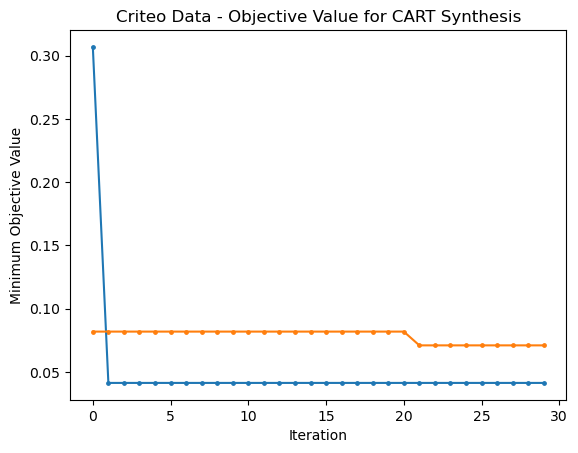

In [ ]:
fig = plt.figure()
plt.plot(run_targets[0])
plt.scatter(np.arange(len(run_targets[0])), run_targets[0], s=6)
plt.plot(run_targets[1])
plt.scatter(np.arange(len(run_targets[1])), run_targets[1], s=6)
plt.title("Criteo Data - Objective Value for CART Synthesis")
plt.xlabel("Iteration")
plt.ylabel("Minimum Objective Value")
plt.show()

In [ ]:
optimization_results

[{'best_params': {'gmm': {},
   'multinomial': {},
   'tree': {'f0': {'min_samples_leaf': 244.8621039800519},
    'f1': {'min_samples_leaf': 1.0},
    'f2': {'min_samples_leaf': 1.0},
    'f3': {'min_samples_leaf': 209.99043618567933},
    'f4': {'min_samples_leaf': 1.0},
    'f5': {'min_samples_leaf': 980.921274436054},
    'f6': {'min_samples_leaf': 737.4558240370601},
    'f7': {'min_samples_leaf': 1.0},
    'f8': {'min_samples_leaf': 7736.882191715049},
    'f9': {'min_samples_leaf': 1.0},
    'f10': {'min_samples_leaf': 1.0},
    'f11': {'min_samples_leaf': 609.36680197454}}},
  'best_score': 0.04136585157397875,
  'optimizer': <bayes_opt.bayesian_optimization.BayesianOptimization at 0x2387ff6d190>},
 {'best_params': {'gmm': {},
   'multinomial': {},
   'tree': {'f0': {'min_samples_leaf': 837.166865860258},
    'f1': {'min_samples_leaf': 1.0},
    'f2': {'min_samples_leaf': 1.0},
    'f3': {'min_samples_leaf': 803.1861305952272},
    'f4': {'min_samples_leaf': 1.0},
    'f5': {'mi

In [ ]:
best_params = optimization_results[np.argmin([x['best_score'] for x in optimization_results])]['best_params']

In [ ]:
best_params

{'gmm': {},
 'multinomial': {},
 'tree': {'f0': {'min_samples_leaf': 244.8621039800519},
  'f1': {'min_samples_leaf': 1.0},
  'f2': {'min_samples_leaf': 1.0},
  'f3': {'min_samples_leaf': 209.99043618567933},
  'f4': {'min_samples_leaf': 1.0},
  'f5': {'min_samples_leaf': 980.921274436054},
  'f6': {'min_samples_leaf': 737.4558240370601},
  'f7': {'min_samples_leaf': 1.0},
  'f8': {'min_samples_leaf': 7736.882191715049},
  'f9': {'min_samples_leaf': 1.0},
  'f10': {'min_samples_leaf': 1.0},
  'f11': {'min_samples_leaf': 609.36680197454}}}

In [ ]:
warnings.filterwarnings('ignore')

# again, we are silencing harmless overflow warnings from numpy related to the Yeo-johnson transformation

sds, full_sXs = perform_synthesis_with_param_target(
    train_data=train_data,
    number_synthetic_datasets=20,
    synthesis_steps=synthesis_steps,
    target_params=target_params,
    target_variable=target_variable,
    exog_variables=exog_variables,
    param_values=best_params
)

In [ ]:
np.mean(sds)

0.08121896184711254

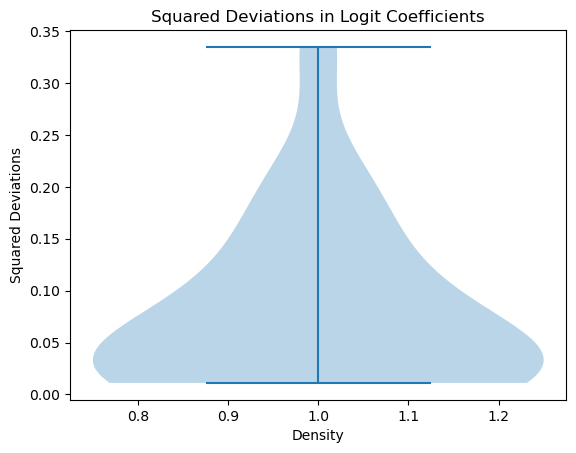

In [ ]:
plt.violinplot(sds)
plt.xlabel("Density")
plt.ylabel("Squared Deviations")
plt.title("Squared Deviations in Logit Coefficients")
plt.show()

In [ ]:
synthetic_data_path = "../../Data/Criteo/"

for i, sX in enumerate(full_sXs):
    if not os.path.exists(synthetic_data_path):
        os.makedirs(synthetic_data_path)
    sX.to_csv(synthetic_data_path + "cart_" + str(i) + "_" + data_set + ".csv", index=False)

End of file.